In [10]:
%matplotlib inline
import netCDF4 as nc
import numpy as np
import datetime as DT
import sys, pickle
sys.path.append('/home/spike/repos')
from testbedutils import sblib as sb
from getdatatestbed import getDataFRF
from testbedutils import waveLib as wl
sys.path.append('/home/spike/cmtb')
from plotting.nonoperationalPlots import plot_scatterAndQQ
import researchLib as RL
from matplotlib import pyplot as plt 

##################################################################
start = DT.datetime(2015, 10, 1)
end = DT.datetime(2016, 10, 1)
IGcutoff = 1/25  # frequency seconds for infragravity cut off
HFcutoff = 1/2.  # high frequency cutoff

This is a notebook demonstrating directional spread issues as measured from acoustic instruments.  The problem specifically arises when doing half planed comparisons which are comparisons using only the shorewardly incident energy (eg between -18 and 162 degrees true North --at the FRF).  The mean direction problems documented are a symptom as documented by Herbers in 2009
https://journals.ametsoc.org/doi/pdf/10.1175/2009JTECHO681.1

In [85]:
def halfPlanePolarPlot(spectra, frequencies, directions, lims=[-18, 162], **kwargs):
    """ creates single polar plot for spectra 
    
    Args:
        spectra (array): 2D array only
        frequencies (array): 1 d array of corresponding frequencies to spectra
        directions(array): directions associated with spectra
        lims (list): default is half plane for Duck (incident energy only), will NOT truncate spectra
            set to None if looking to plot whole 360 polar plot
    
    Keyword Args:
        'contour_levels'(list): a list of contour levels to color
        'figsize' (tup): a tuple of figure size eg. (12, 10)
        'fname' (str): file path save name
    Returns:
        Axis object 
            
    """  
    # begin by checking inputs
    assert np.array(spectra).ndim == 2, 'spectra needs to be 2 dimensional'
    assert np.array(spectra).shape[0] == np.array(frequencies).shape[0], 'spectra should be shaped by freq then direction'
    assert np.array(spectra).shape[1] == np.array(directions).shape[0], 'spectra should be shaped by freq then direction'
    # pre-processing spectra
    Edarray = np.asarray(spectra, dtype=object)                  # make spectra an array (if not already )
    Ednew = np.append(spectra, spectra[:,0:1], axis=1)           # add extra directional band to get it to wrap 
    Dmean_rad = np.deg2rad(np.append(directions, directions[0])) # convert input directions to radian
    ## set Color-scale
    if 'contour_levels' in kwargs:                               # manually set contours
        contour_levels = kwargs['contour_levels']
    else:                                                        # automatically set contours 
        Edmax = float(np.max(spectra))                           # take max for colorbars
        contourNumber = 50                                       # set default number of contour levels 
        minlevel = Edmax/contourNumber                           # calculate min level 
        maxlevel = Edmax                                         # calculate max level
        step = (maxlevel - minlevel)/contourNumber               # associated step 
        contour_levels = np.arange(minlevel, maxlevel, step)     # create list/array of contour levels for plot
    if 'figsize' in kwargs:
        figSize = kwargs['figsize']
    else: 
        figSize=(11,11)
    ########################################################################
    fig = plt.figure(figsize=figSize)                                   # create figure 
    thetas = Dmean_rad[:] # in radian NOT DEGREES 

    ax = plt.subplot(111, polar=True)                                   # create polar axis object 
    ax.set_theta_direction(-1)                                          # set to counter clock-wise plot  
    ax.set_theta_zero_location("N")                                     # set zero as up 
    colorax = ax.contourf(thetas, frequencies, Ednew, contour_levels)   # make plot

    ## Set titles and colorbar
    plt.suptitle('Polar Spectrum ', fontsize=22, y=0.95, x=0.45)
    cbar = fig.colorbar(colorax)
    cbar.set_label('Energy Density ($m^2/Hz/deg$)', rotation=270, fontsize=16)
    cbar.ax.get_yaxis().labelpad = 30

    #     degrange = range(0,360,30)
    #     lines, labels = plt.thetagrids(degrange, labels=None, frac = 1.07)
    if lims is not None:  
        ax.set_thetalim(np.deg2rad(lims))
    if 'fname' in kwargs:
        plt.savefig(kwargs['fname']); plt.close()
        
    return ax

# Get Observations  and model data

In [175]:
gauge = 'awac-6m'
modlabel = '8m-array'
obslabel = gauge

go = getDataFRF.getObs(start, end)
obs = go.getWaveSpec(gauge, removeBadDataFlag=3)
HPspecs, HPdirs = wl.HPchop_spec(obs['dWED'], obs['wavedirbin'], angadj=72)
mod = go.getWaveSpec('8m-array', removeBadDataFlag=3)

#gm = getDataFRF.getDataTestBed(start, end)
#gm.getWaveSpecModel('HP', '8m-array', model='STWAVE')


In [250]:
obs.keys()

dict_keys(['time', 'epochtime', 'name', 'wavefreqbin', 'xFRF', 'yFRF', 'lat', 'lon', 'Hs', 'depth', 'wavedirbin', 'dWED', 'fspec', 'peakf', 'waveDp', 'waveDm', 'qcFlagE', 'qcFlagD'])

# Now Show problem then isolate test case

In [176]:
#first time match 
matchedTime, idxobs, idxmod = sb.timeMatch(obs_time=obs['time'], obs_data=None, model_time=mod['time'], model_data=None)
mod_matched = sb.reduceDict(mod, idxmod)
obs_matched = sb.reduceDict(obs, idxobs)
# calculate stats  for Full plane 
mod_bulkStat_FP = wl.waveStat(mod_matched['dWED'], mod_matched['wavefreqbin'], mod_matched['wavedirbin'])
obs_bulkStat_FP = wl.waveStat(obs_matched['dWED'], obs_matched['wavefreqbin'], obs_matched['wavedirbin'])
# now Half plane 
mod_bulkStat_HP = RL.replaceWaveDictHalfPlaneSpectralStats(mod_matched, freqLims=(IGcutoff, HFcutoff))
obs_bulkStat_HP = RL.replaceWaveDictHalfPlaneSpectralStats(obs_matched, freqLims=(IGcutoff, HFcutoff))

Text(0.5,0,'Full-planed Directions [deg TN]')

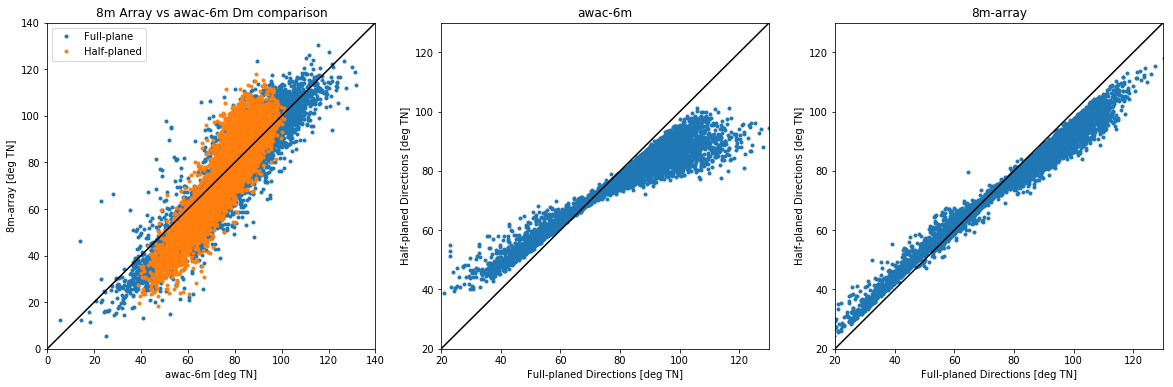

In [256]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.title('8m Array vs {} Dm comparison'.format(gauge))
plt.plot(obs_bulkStat_FP['Dm'], mod_bulkStat_FP['Dm'], '.', label='Full-plane')
plt.plot(obs_bulkStat_HP['Dm'], mod_bulkStat_HP['Dm'], '.', label='Half-planed')
plt.plot([0,180], [0, 180], 'k-')
plt.xlabel(obslabel + ' [deg TN]')
plt.ylabel(modlabel + ' [deg TN]')
plt.xlim([0,140])
plt.ylim([0, 140])
plt.legend()
plt.subplot(132)
plt.plot(obs_bulkStat_FP['Dm'], obs_bulkStat_HP['Dm'], '.')
plt.plot([0,130], [0, 130], 'k-')
plt.ylim([20, 130])
plt.xlim([20, 130])
plt.title('{}'.format(gauge))
plt.ylabel('Half-planed Directions [deg TN]')
plt.xlabel('Full-planed Directions [deg TN]')
plt.subplot(133)
plt.plot(mod_bulkStat_FP['Dm'], mod_bulkStat_HP['Dm'], '.')
plt.plot([0,130], [0, 130], 'k-')
plt.ylim([20, 130])
plt.xlim([20, 130])
plt.title('{}'.format(modlabel))
plt.ylabel('Half-planed Directions [deg TN]')
plt.xlabel('Full-planed Directions [deg TN]')

In half plane, the Dm produced from the acoustic gauge moves energy more shore normal than with the 8m-array.  If there was similar spread, the half-plane comparison would have a similar slope to the full plane (left panel).  The issue produces the added (positive) slope to the data seen in the Half-plane plot in the above left panel.

The right panel shows a comparsion specifically at the acoustic gauge between the full and half plane mean Directions.   The issue is more prevalent with waves approaching from the south. 

In [228]:
# create residuals between the HP and FP results and isolate the largest residuals
dirResiual_acoustic = obs_bulkStat_FP['Dm'] - obs_bulkStat_HP['Dm'] 
dirResiual_8m = mod_bulkStat_FP['Dm'] - mod_bulkStat_HP['Dm'] 


### Now plot the direction residual against wave height

Text(0,0.5,'Full Plane Dm')

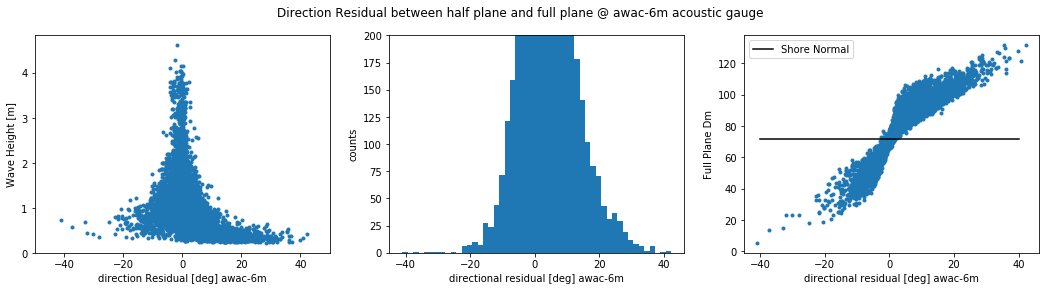

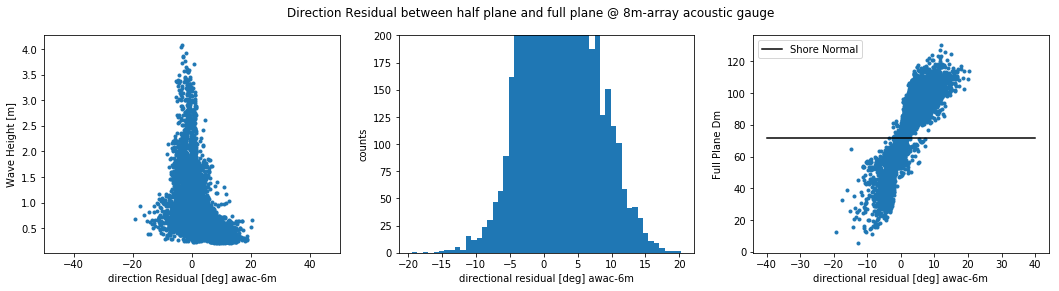

In [252]:
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.plot( dirResiual_acoustic, obs_bulkStat_FP['Hm0'],'.')
plt.ylabel('Wave Height [m]')
plt.xlabel('direction Residual [deg] {}'.format(gauge))
plt.suptitle('Direction Residual between half plane and full plane @ {} acoustic gauge'.format(gauge))
plt.xlim([-50, 50])
plt.subplot(132)
_ = plt.hist(dirResiual_acoustic, bins=50)
plt.ylim([0,200])
plt.ylabel('counts')
plt.xlabel('directional residual [deg] {}'.format(gauge))
plt.subplot(133)
plt.plot( dirResiual_acoustic,obs_bulkStat_FP['Dm'],'.')
plt.plot([-40, 40], [72, 72], 'k-', label='Shore Normal')
plt.legend()
plt.xlabel('directional residual [deg] {}'.format(gauge))
plt.ylabel('Full Plane Dm')

plt.figure(figsize=(18,4))
plt.subplot(131)
plt.plot( dirResiual_8m, mod_bulkStat_FP['Hm0'],'.')
plt.ylabel('Wave Height [m]')
plt.xlabel('direction Residual [deg] {}'.format(gauge))
plt.suptitle('Direction Residual between half plane and full plane @ {} acoustic gauge'.format(modlabel))
plt.xlim([-50, 50])
plt.subplot(132)
_ = plt.hist(dirResiual_8m, bins=50)
plt.ylim([0,200])
plt.ylabel('counts')
plt.xlabel('directional residual [deg] {}'.format(gauge))
plt.subplot(133)
plt.plot( dirResiual_8m,mod_bulkStat_FP['Dm'],'.')
plt.plot([-40, 40], [72, 72], 'k-', label='Shore Normal')
plt.legend()
plt.xlabel('directional residual [deg] {}'.format(gauge))
plt.ylabel('Full Plane Dm')


There's a clear problem during smaller waves between half-plane and full-planed spectra.  this is related to the added noise of the narrow banded acoustic gauge. (left panel)

The residual is close to normally distributed with a center sslightly positive (+) of zero, again showing that the issue is more prevalent with waves approaching from the south. (center)

The directional residual grows as incident (Full plane) wave angle becomes more oblique. (right)

### now Compare this directional residual to the 8m array which we consider truth


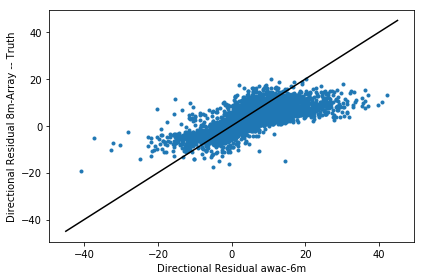

In [240]:
plt.subplot(111)
plt.plot(dirResiual_acoustic,dirResiual_8m,'.')
plt.plot([-45, 45], [-45, 45], 'k-')
plt.ylabel('Directional Residual 8m-Array -- Truth')
plt.xlabel('Directional Residual {}'.format(gauge))
plt.tight_layout()

This shows that the directional residual with the acoustic gauge, while it follows similar trends, is much wider than that of the 8m array.  This is too be expected, but the amount of spread I consider surprising, at the  extremes 30 degrees difference!

In [241]:
# begin isolation of specific spectra
threshLower = 10  # look for values bigger than this 
threshUpper = 20
idxHighResidual = np.argwhere((np.abs(dirResiual_acoustic) > threshLower) & (obs_bulkStat_FP['Hm0']>0.75)).squeeze()
# obs_matched_HP['time'][idxHighResidual]
# idxOfInterest = idxHighResidual[6] # pick random index of interest from list 
# listInterest = [2, 4, 5, 6, 12, 18, 34]

# Begin looking at spectra
below are plots of wave spectra from the 8m array and the acoustic gauge (selected above). 
Specifically isolated are times when there is a Dm residual between 10 and 20 degrees for Half plane and Full plane 
(only when there is less than 0.05 m Hm0 differences between the two gauges -- in FP)
For Each Plot: 
the energy above the __Black line__ is ocean propagating (162), and the __white line__ is shore normal (72).  The Northern boundary for shore/ocean propagation was left out for clarity (its around 342).

Above each pair of plots is the date/time of the plot.  The 2nd line shows the Full plane statistics Hm0 and D_m for the acoustic gauge and the 8m array. The 3rd line shows the Half-planed bulk statistic and the last line shows the difference between full and half.  

Note: The color bars are the same between both plots, but the max has been reduced to 75% of the maximum value between the two spectra.  This was done to highlight the lower energy portions of the spectrum (the directional spread). 

2015-10-10 13:00:00
awac-6m FP H_s: 1.00 [m] D_m 31.82 [deg] ........ 8m-array FP H_s: 0.99 [m] D_m: 23.15 [deg]
awac-6m HP H_s: 0.85 [m] D_m 47.17 [deg] ........ 8m-array HP H_s: 0.91 [m] D_m: 30.66 [deg]
HP diff     H_s: 0.14 [m] D_m -15.34 [deg] ........             H_s: 0.07 [m] D_m: -7.51 [deg]


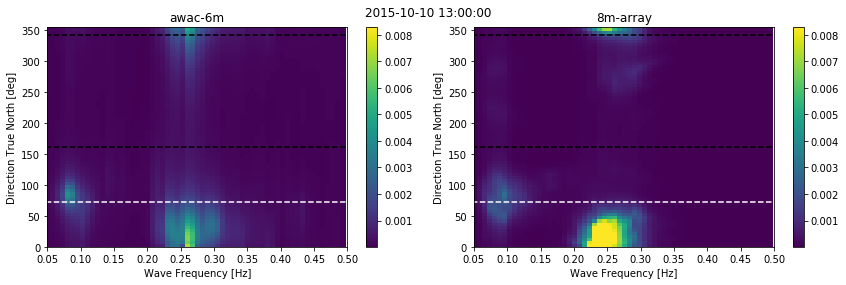

2015-10-18 22:00:00
awac-6m FP H_s: 0.96 [m] D_m 39.06 [deg] ........ 8m-array FP H_s: 0.99 [m] D_m: 37.34 [deg]
awac-6m HP H_s: 0.85 [m] D_m 49.37 [deg] ........ 8m-array HP H_s: 0.96 [m] D_m: 40.28 [deg]
HP diff     H_s: 0.12 [m] D_m -10.31 [deg] ........             H_s: 0.04 [m] D_m: -2.94 [deg]


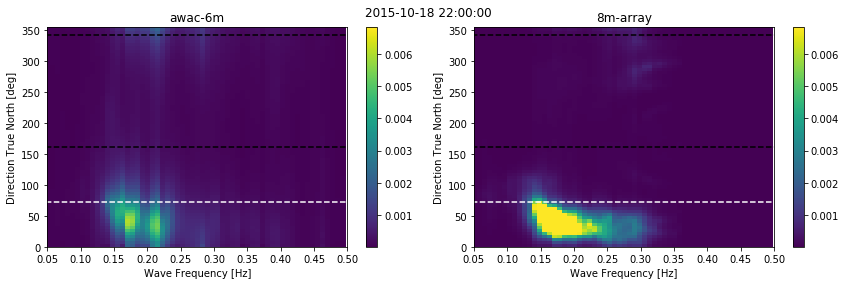

2015-11-14 15:00:00
awac-6m FP H_s: 1.15 [m] D_m 39.33 [deg] ........ 8m-array FP H_s: 1.13 [m] D_m: 36.70 [deg]
awac-6m HP H_s: 1.02 [m] D_m 49.53 [deg] ........ 8m-array HP H_s: 1.08 [m] D_m: 40.38 [deg]
HP diff     H_s: 0.13 [m] D_m -10.20 [deg] ........             H_s: 0.06 [m] D_m: -3.68 [deg]


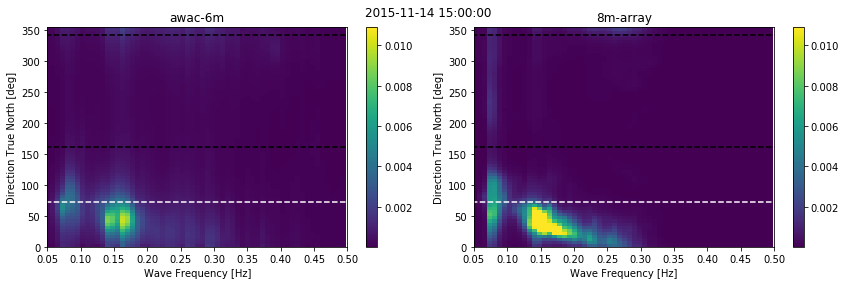

2015-12-03 13:00:00
awac-6m FP H_s: 0.78 [m] D_m 38.38 [deg] ........ 8m-array FP H_s: 0.75 [m] D_m: 27.12 [deg]
awac-6m HP H_s: 0.66 [m] D_m 53.30 [deg] ........ 8m-array HP H_s: 0.72 [m] D_m: 30.66 [deg]
HP diff     H_s: 0.12 [m] D_m -14.92 [deg] ........             H_s: 0.03 [m] D_m: -3.53 [deg]


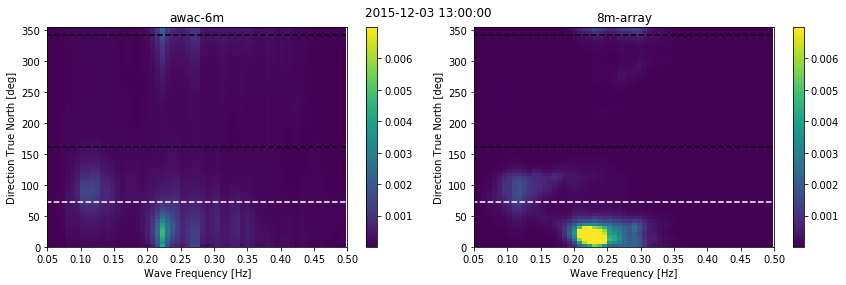

2015-12-03 15:00:00
awac-6m FP H_s: 0.83 [m] D_m 27.31 [deg] ........ 8m-array FP H_s: 0.88 [m] D_m: 25.41 [deg]
awac-6m HP H_s: 0.69 [m] D_m 47.67 [deg] ........ 8m-array HP H_s: 0.84 [m] D_m: 30.16 [deg]
HP diff     H_s: 0.14 [m] D_m -20.36 [deg] ........             H_s: 0.04 [m] D_m: -4.75 [deg]


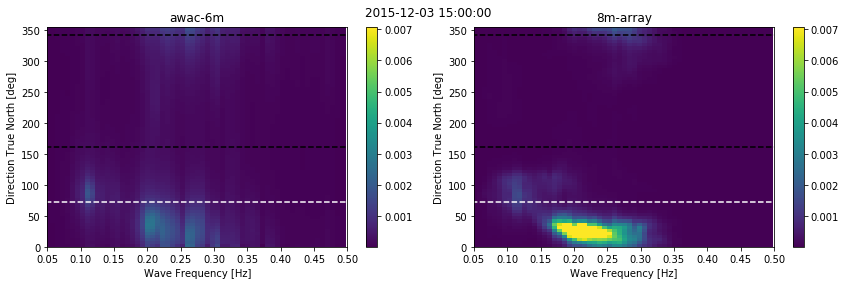

2015-12-03 16:00:00
awac-6m FP H_s: 1.00 [m] D_m 30.50 [deg] ........ 8m-array FP H_s: 0.96 [m] D_m: 26.46 [deg]
awac-6m HP H_s: 0.85 [m] D_m 45.96 [deg] ........ 8m-array HP H_s: 0.91 [m] D_m: 31.03 [deg]
HP diff     H_s: 0.15 [m] D_m -15.46 [deg] ........             H_s: 0.05 [m] D_m: -4.58 [deg]


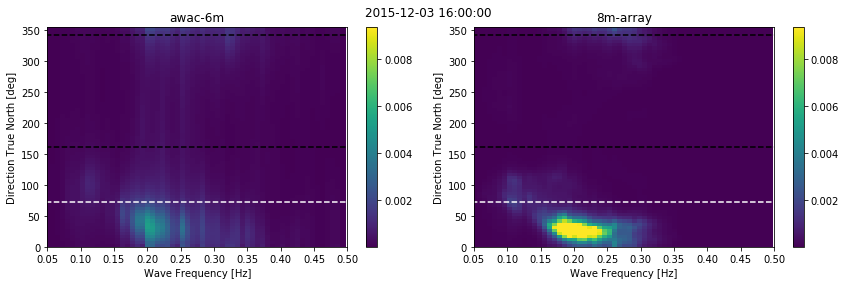

2015-12-03 17:00:00
awac-6m FP H_s: 1.03 [m] D_m 27.58 [deg] ........ 8m-array FP H_s: 1.04 [m] D_m: 26.84 [deg]
awac-6m HP H_s: 0.90 [m] D_m 41.72 [deg] ........ 8m-array HP H_s: 1.00 [m] D_m: 30.96 [deg]
HP diff     H_s: 0.13 [m] D_m -14.14 [deg] ........             H_s: 0.05 [m] D_m: -4.12 [deg]


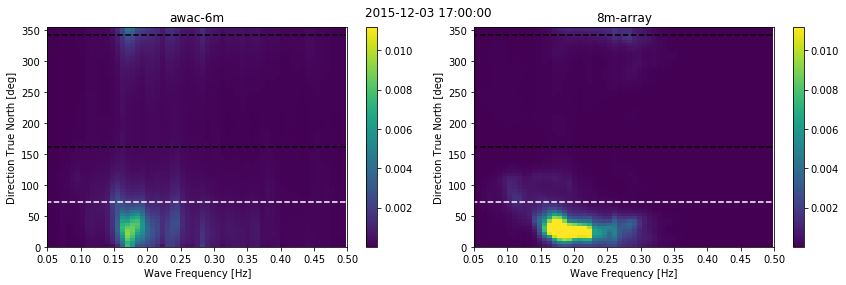

2015-12-03 19:00:00
awac-6m FP H_s: 0.98 [m] D_m 34.21 [deg] ........ 8m-array FP H_s: 0.97 [m] D_m: 26.78 [deg]
awac-6m HP H_s: 0.86 [m] D_m 46.32 [deg] ........ 8m-array HP H_s: 0.92 [m] D_m: 32.49 [deg]
HP diff     H_s: 0.12 [m] D_m -12.10 [deg] ........             H_s: 0.06 [m] D_m: -5.71 [deg]


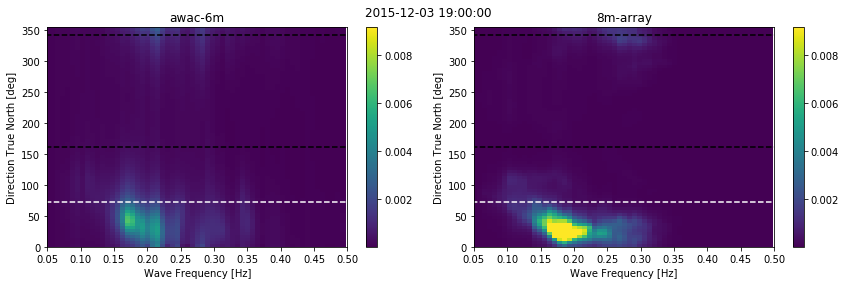

2015-12-04 04:00:00
awac-6m FP H_s: 1.22 [m] D_m 35.73 [deg] ........ 8m-array FP H_s: 1.20 [m] D_m: 29.47 [deg]
awac-6m HP H_s: 1.08 [m] D_m 46.32 [deg] ........ 8m-array HP H_s: 1.14 [m] D_m: 34.27 [deg]
HP diff     H_s: 0.14 [m] D_m -10.59 [deg] ........             H_s: 0.06 [m] D_m: -4.80 [deg]


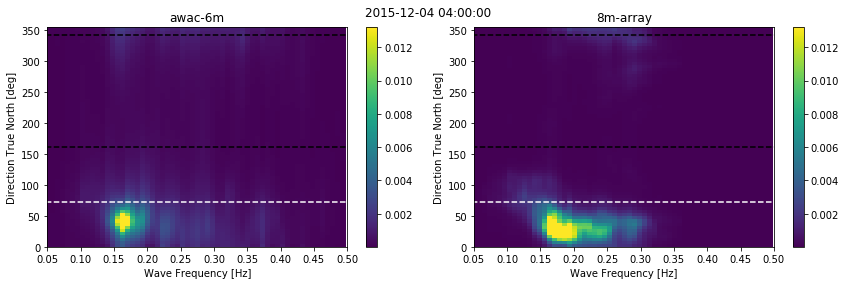

2015-12-15 03:00:00
awac-6m FP H_s: 0.76 [m] D_m 107.07 [deg] ........ 8m-array FP H_s: 0.73 [m] D_m: 106.81 [deg]
awac-6m HP H_s: 0.66 [m] D_m 93.33 [deg] ........ 8m-array HP H_s: 0.66 [m] D_m: 98.36 [deg]
HP diff     H_s: 0.10 [m] D_m 13.75 [deg] ........             H_s: 0.07 [m] D_m: 8.44 [deg]


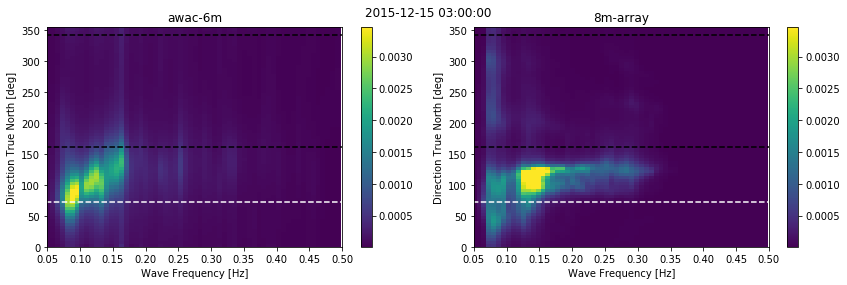

2015-12-19 10:00:00
awac-6m FP H_s: 0.84 [m] D_m 38.77 [deg] ........ 8m-array FP H_s: 0.84 [m] D_m: 33.38 [deg]
awac-6m HP H_s: 0.72 [m] D_m 50.35 [deg] ........ 8m-array HP H_s: 0.80 [m] D_m: 36.61 [deg]
HP diff     H_s: 0.11 [m] D_m -11.58 [deg] ........             H_s: 0.03 [m] D_m: -3.23 [deg]


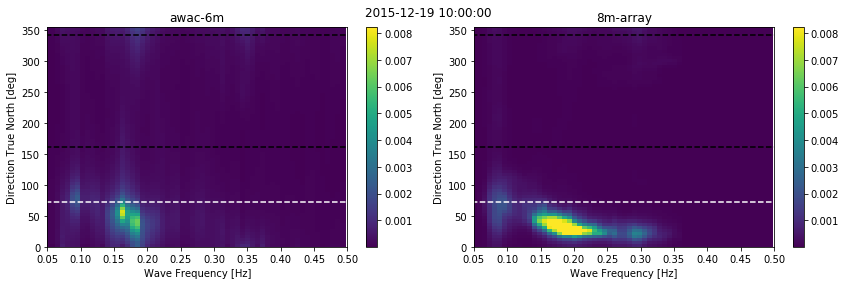

2015-12-24 01:00:00
awac-6m FP H_s: 0.91 [m] D_m 108.54 [deg] ........ 8m-array FP H_s: 0.87 [m] D_m: 108.02 [deg]
awac-6m HP H_s: 0.80 [m] D_m 97.52 [deg] ........ 8m-array HP H_s: 0.82 [m] D_m: 102.88 [deg]
HP diff     H_s: 0.11 [m] D_m 11.02 [deg] ........             H_s: 0.05 [m] D_m: 5.14 [deg]


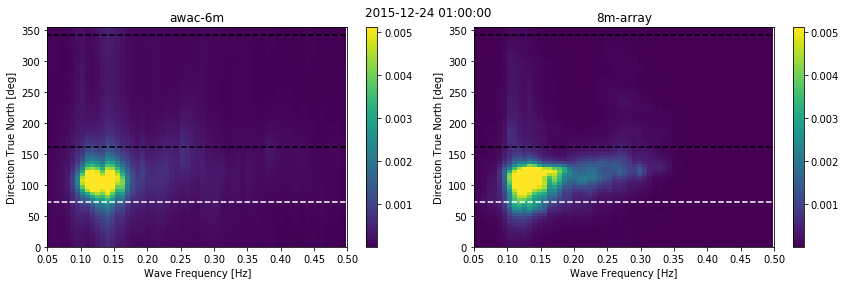

2015-12-24 02:00:00
awac-6m FP H_s: 0.85 [m] D_m 116.39 [deg] ........ 8m-array FP H_s: 0.85 [m] D_m: 105.49 [deg]
awac-6m HP H_s: 0.74 [m] D_m 101.20 [deg] ........ 8m-array HP H_s: 0.81 [m] D_m: 101.56 [deg]
HP diff     H_s: 0.12 [m] D_m 15.18 [deg] ........             H_s: 0.04 [m] D_m: 3.93 [deg]


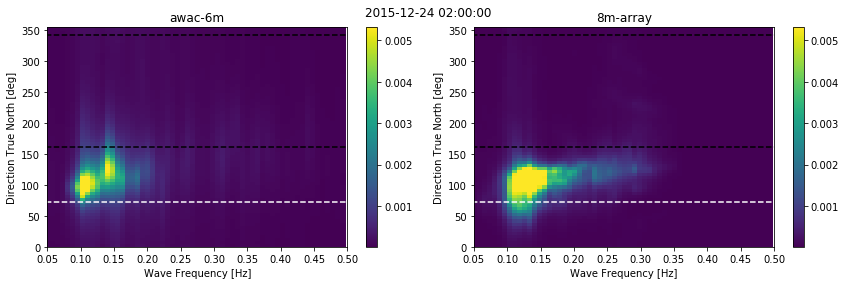

2016-01-19 07:00:00
awac-6m FP H_s: 0.81 [m] D_m 42.46 [deg] ........ 8m-array FP H_s: 0.83 [m] D_m: 30.09 [deg]
awac-6m HP H_s: 0.69 [m] D_m 54.47 [deg] ........ 8m-array HP H_s: 0.79 [m] D_m: 34.34 [deg]
HP diff     H_s: 0.12 [m] D_m -12.01 [deg] ........             H_s: 0.04 [m] D_m: -4.25 [deg]


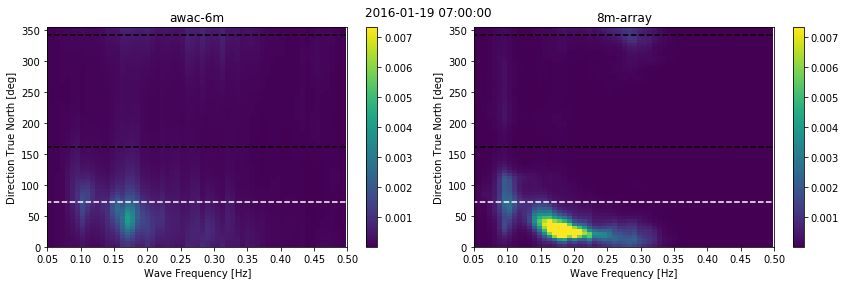

2016-01-19 08:00:00
awac-6m FP H_s: 0.95 [m] D_m 33.55 [deg] ........ 8m-array FP H_s: 0.95 [m] D_m: 25.29 [deg]
awac-6m HP H_s: 0.82 [m] D_m 46.90 [deg] ........ 8m-array HP H_s: 0.90 [m] D_m: 29.89 [deg]
HP diff     H_s: 0.13 [m] D_m -13.35 [deg] ........             H_s: 0.05 [m] D_m: -4.60 [deg]


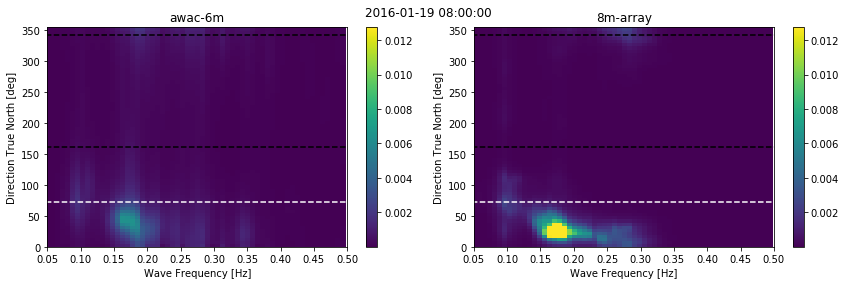

2016-01-19 09:00:00
awac-6m FP H_s: 1.05 [m] D_m 37.81 [deg] ........ 8m-array FP H_s: 1.05 [m] D_m: 24.73 [deg]
awac-6m HP H_s: 0.91 [m] D_m 48.95 [deg] ........ 8m-array HP H_s: 1.00 [m] D_m: 29.07 [deg]
HP diff     H_s: 0.14 [m] D_m -11.15 [deg] ........             H_s: 0.05 [m] D_m: -4.34 [deg]


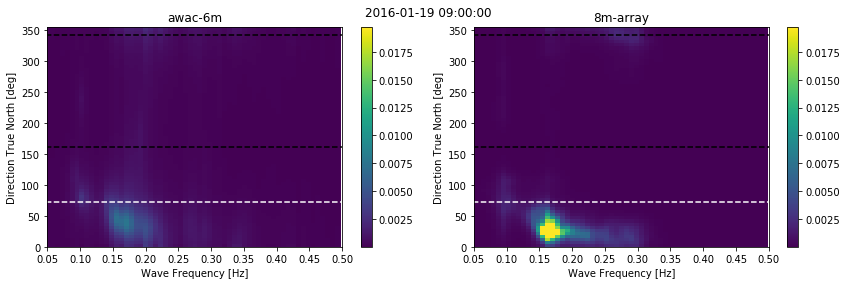

2016-01-19 11:00:00
awac-6m FP H_s: 0.97 [m] D_m 34.87 [deg] ........ 8m-array FP H_s: 0.99 [m] D_m: 27.08 [deg]
awac-6m HP H_s: 0.86 [m] D_m 45.62 [deg] ........ 8m-array HP H_s: 0.95 [m] D_m: 30.32 [deg]
HP diff     H_s: 0.11 [m] D_m -10.74 [deg] ........             H_s: 0.04 [m] D_m: -3.24 [deg]


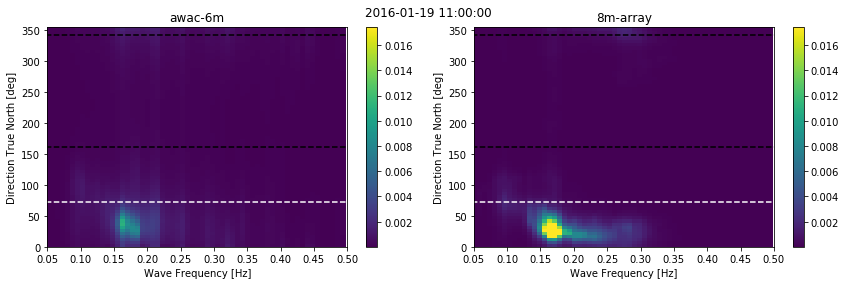

2016-01-19 13:00:00
awac-6m FP H_s: 0.85 [m] D_m 38.63 [deg] ........ 8m-array FP H_s: 0.84 [m] D_m: 26.82 [deg]
awac-6m HP H_s: 0.74 [m] D_m 48.70 [deg] ........ 8m-array HP H_s: 0.81 [m] D_m: 30.55 [deg]
HP diff     H_s: 0.11 [m] D_m -10.07 [deg] ........             H_s: 0.03 [m] D_m: -3.73 [deg]


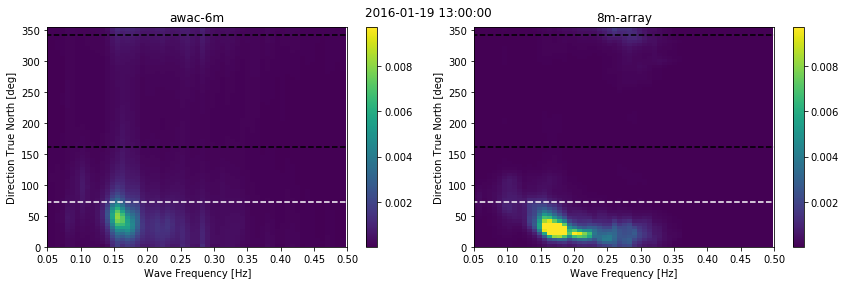

2016-01-19 14:00:00
awac-6m FP H_s: 0.78 [m] D_m 35.81 [deg] ........ 8m-array FP H_s: 0.80 [m] D_m: 27.94 [deg]
awac-6m HP H_s: 0.67 [m] D_m 48.84 [deg] ........ 8m-array HP H_s: 0.76 [m] D_m: 31.96 [deg]
HP diff     H_s: 0.11 [m] D_m -13.03 [deg] ........             H_s: 0.03 [m] D_m: -4.02 [deg]


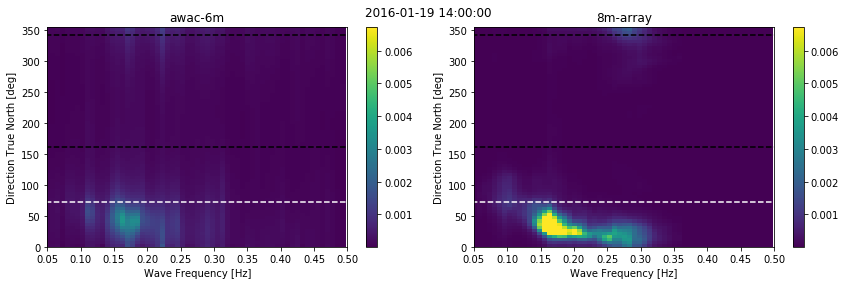

2016-01-19 15:00:00
awac-6m FP H_s: 0.82 [m] D_m 36.53 [deg] ........ 8m-array FP H_s: 0.82 [m] D_m: 31.21 [deg]
awac-6m HP H_s: 0.71 [m] D_m 49.07 [deg] ........ 8m-array HP H_s: 0.79 [m] D_m: 33.91 [deg]
HP diff     H_s: 0.11 [m] D_m -12.55 [deg] ........             H_s: 0.03 [m] D_m: -2.70 [deg]


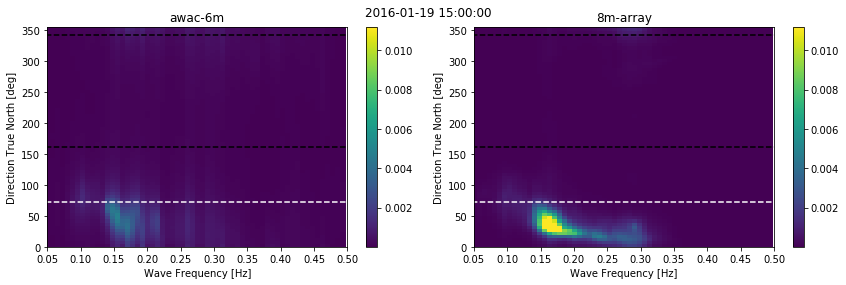

2016-01-19 18:00:00
awac-6m FP H_s: 0.81 [m] D_m 35.81 [deg] ........ 8m-array FP H_s: 0.80 [m] D_m: 28.64 [deg]
awac-6m HP H_s: 0.70 [m] D_m 48.53 [deg] ........ 8m-array HP H_s: 0.77 [m] D_m: 32.94 [deg]
HP diff     H_s: 0.11 [m] D_m -12.72 [deg] ........             H_s: 0.04 [m] D_m: -4.30 [deg]


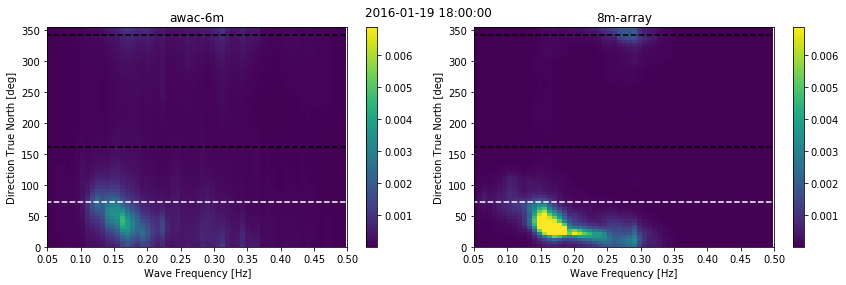

2016-01-19 19:00:00
awac-6m FP H_s: 0.79 [m] D_m 37.57 [deg] ........ 8m-array FP H_s: 0.76 [m] D_m: 28.14 [deg]
awac-6m HP H_s: 0.69 [m] D_m 48.19 [deg] ........ 8m-array HP H_s: 0.72 [m] D_m: 32.39 [deg]
HP diff     H_s: 0.10 [m] D_m -10.62 [deg] ........             H_s: 0.03 [m] D_m: -4.24 [deg]


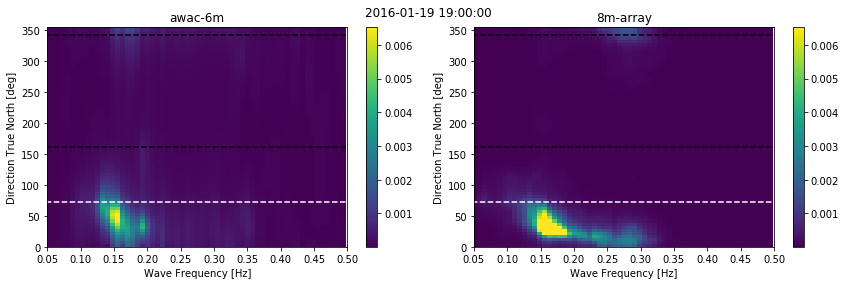

2016-01-19 20:00:00
awac-6m FP H_s: 0.78 [m] D_m 31.40 [deg] ........ 8m-array FP H_s: 0.75 [m] D_m: 26.39 [deg]
awac-6m HP H_s: 0.68 [m] D_m 45.95 [deg] ........ 8m-array HP H_s: 0.71 [m] D_m: 30.72 [deg]
HP diff     H_s: 0.11 [m] D_m -14.55 [deg] ........             H_s: 0.03 [m] D_m: -4.33 [deg]


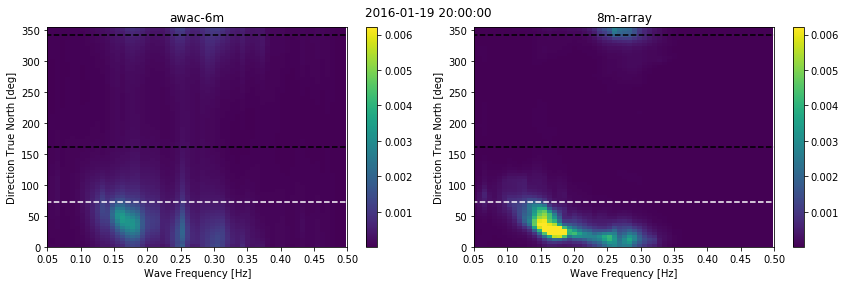

2016-01-19 21:00:00
awac-6m FP H_s: 0.82 [m] D_m 33.42 [deg] ........ 8m-array FP H_s: 0.81 [m] D_m: 23.02 [deg]
awac-6m HP H_s: 0.71 [m] D_m 46.67 [deg] ........ 8m-array HP H_s: 0.77 [m] D_m: 28.03 [deg]
HP diff     H_s: 0.11 [m] D_m -13.25 [deg] ........             H_s: 0.04 [m] D_m: -5.02 [deg]


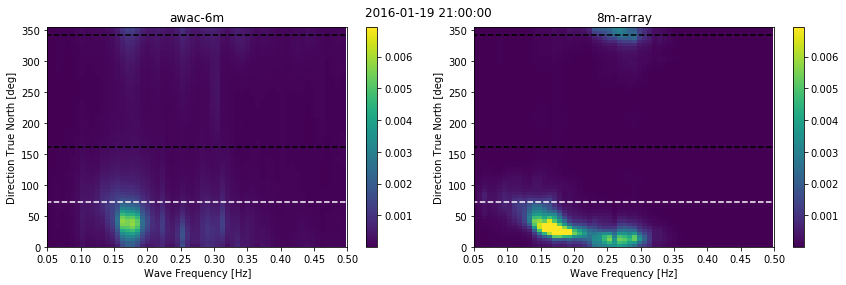

2016-01-19 23:00:00
awac-6m FP H_s: 0.88 [m] D_m 37.19 [deg] ........ 8m-array FP H_s: 0.87 [m] D_m: 25.68 [deg]
awac-6m HP H_s: 0.77 [m] D_m 48.58 [deg] ........ 8m-array HP H_s: 0.83 [m] D_m: 29.86 [deg]
HP diff     H_s: 0.11 [m] D_m -11.39 [deg] ........             H_s: 0.04 [m] D_m: -4.18 [deg]


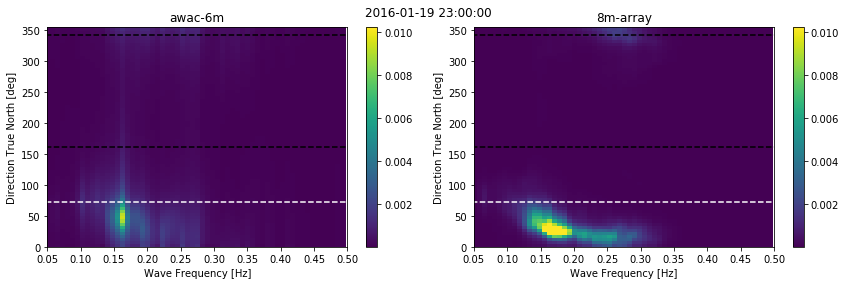

2016-01-20 09:00:00
awac-6m FP H_s: 0.79 [m] D_m 43.74 [deg] ........ 8m-array FP H_s: 0.81 [m] D_m: 20.95 [deg]
awac-6m HP H_s: 0.68 [m] D_m 54.16 [deg] ........ 8m-array HP H_s: 0.77 [m] D_m: 25.84 [deg]
HP diff     H_s: 0.11 [m] D_m -10.42 [deg] ........             H_s: 0.04 [m] D_m: -4.89 [deg]


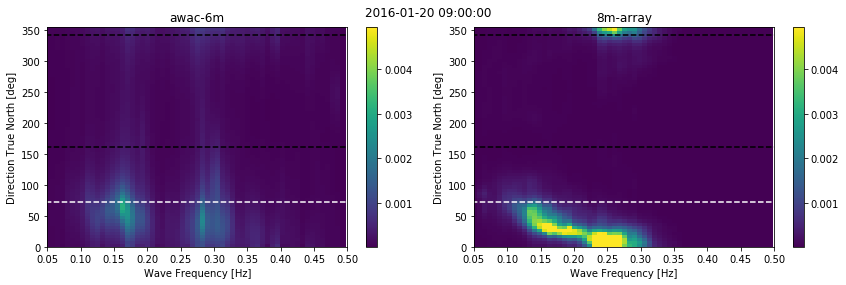

2016-01-20 11:00:00
awac-6m FP H_s: 0.84 [m] D_m 30.70 [deg] ........ 8m-array FP H_s: 0.81 [m] D_m: 25.48 [deg]
awac-6m HP H_s: 0.71 [m] D_m 46.48 [deg] ........ 8m-array HP H_s: 0.78 [m] D_m: 29.42 [deg]
HP diff     H_s: 0.12 [m] D_m -15.78 [deg] ........             H_s: 0.03 [m] D_m: -3.94 [deg]


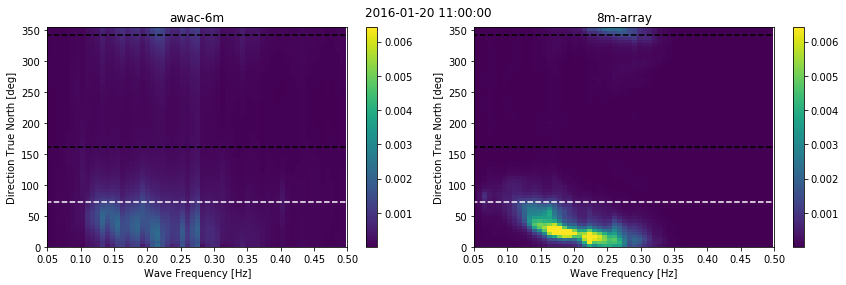

2016-01-20 13:00:00
awac-6m FP H_s: 0.78 [m] D_m 35.72 [deg] ........ 8m-array FP H_s: 0.80 [m] D_m: 28.21 [deg]
awac-6m HP H_s: 0.68 [m] D_m 48.63 [deg] ........ 8m-array HP H_s: 0.77 [m] D_m: 32.33 [deg]
HP diff     H_s: 0.10 [m] D_m -12.91 [deg] ........             H_s: 0.03 [m] D_m: -4.12 [deg]


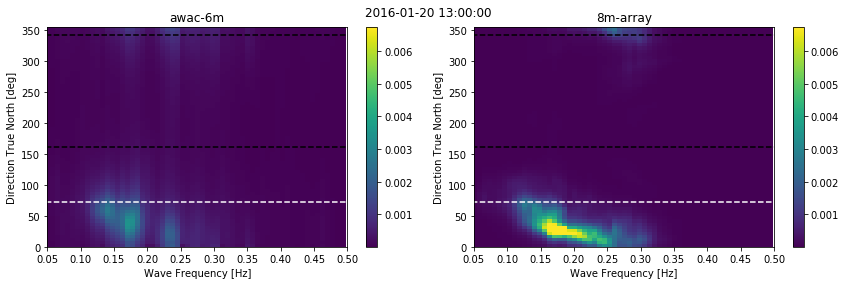

2016-01-21 19:00:00
awac-6m FP H_s: 0.94 [m] D_m 33.35 [deg] ........ 8m-array FP H_s: 0.91 [m] D_m: 22.22 [deg]
awac-6m HP H_s: 0.82 [m] D_m 45.59 [deg] ........ 8m-array HP H_s: 0.85 [m] D_m: 28.54 [deg]
HP diff     H_s: 0.12 [m] D_m -12.24 [deg] ........             H_s: 0.06 [m] D_m: -6.32 [deg]


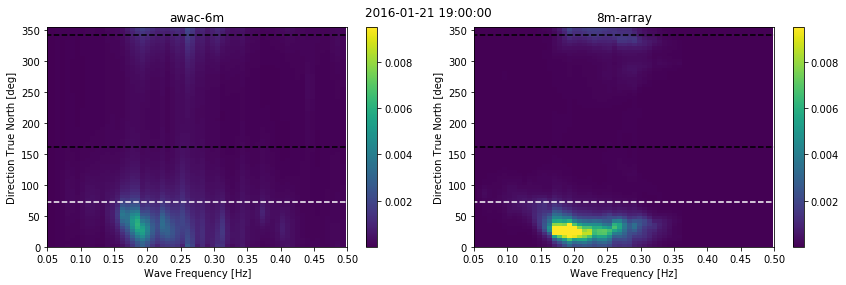

2016-01-21 20:00:00
awac-6m FP H_s: 0.84 [m] D_m 29.51 [deg] ........ 8m-array FP H_s: 0.84 [m] D_m: 24.60 [deg]
awac-6m HP H_s: 0.72 [m] D_m 44.57 [deg] ........ 8m-array HP H_s: 0.79 [m] D_m: 30.64 [deg]
HP diff     H_s: 0.12 [m] D_m -15.06 [deg] ........             H_s: 0.05 [m] D_m: -6.04 [deg]


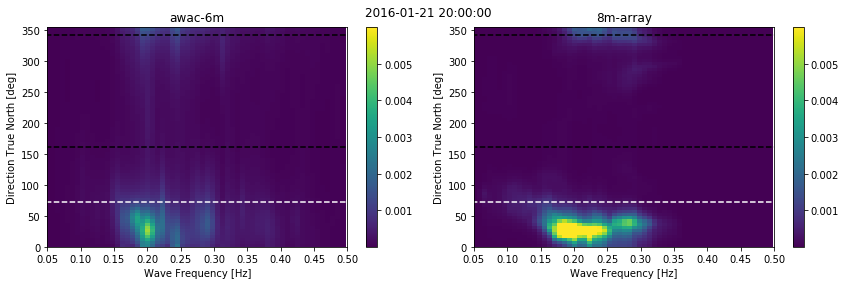

2016-01-27 17:00:00
awac-6m FP H_s: 1.06 [m] D_m 42.84 [deg] ........ 8m-array FP H_s: 1.03 [m] D_m: 25.27 [deg]
awac-6m HP H_s: 0.90 [m] D_m 56.09 [deg] ........ 8m-array HP H_s: 0.96 [m] D_m: 32.28 [deg]
HP diff     H_s: 0.15 [m] D_m -13.25 [deg] ........             H_s: 0.07 [m] D_m: -7.00 [deg]


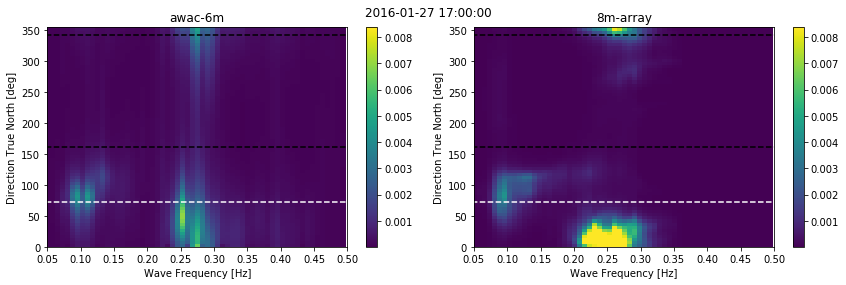

2016-02-13 14:00:00
awac-6m FP H_s: 0.87 [m] D_m 41.24 [deg] ........ 8m-array FP H_s: 0.84 [m] D_m: 24.00 [deg]
awac-6m HP H_s: 0.75 [m] D_m 53.55 [deg] ........ 8m-array HP H_s: 0.78 [m] D_m: 32.56 [deg]
HP diff     H_s: 0.12 [m] D_m -12.30 [deg] ........             H_s: 0.07 [m] D_m: -8.56 [deg]


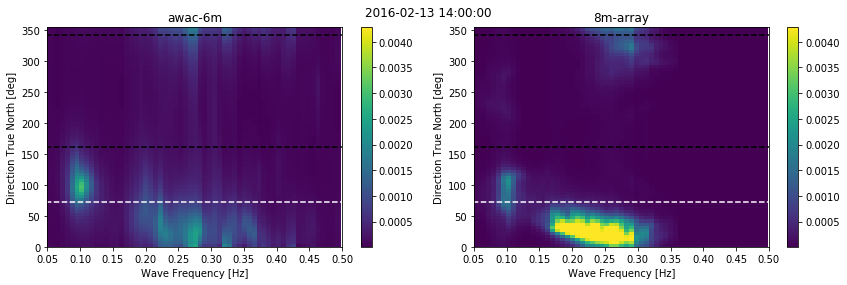

2016-02-13 16:00:00
awac-6m FP H_s: 1.18 [m] D_m 30.24 [deg] ........ 8m-array FP H_s: 1.20 [m] D_m: 27.61 [deg]
awac-6m HP H_s: 1.05 [m] D_m 41.16 [deg] ........ 8m-array HP H_s: 1.13 [m] D_m: 33.39 [deg]
HP diff     H_s: 0.14 [m] D_m -10.92 [deg] ........             H_s: 0.07 [m] D_m: -5.78 [deg]


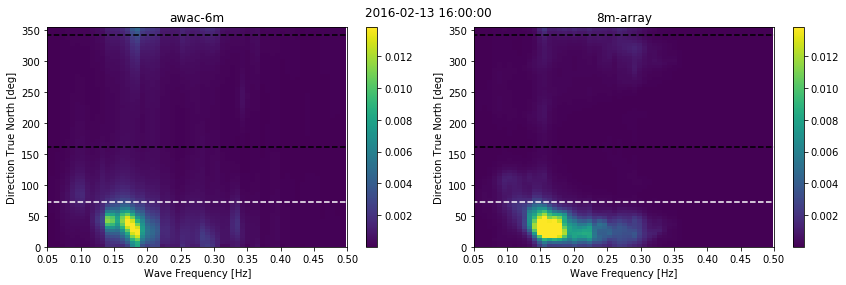

2016-02-27 12:00:00
awac-6m FP H_s: 0.85 [m] D_m 38.63 [deg] ........ 8m-array FP H_s: 0.84 [m] D_m: 30.16 [deg]
awac-6m HP H_s: 0.74 [m] D_m 50.74 [deg] ........ 8m-array HP H_s: 0.81 [m] D_m: 33.35 [deg]
HP diff     H_s: 0.11 [m] D_m -12.11 [deg] ........             H_s: 0.03 [m] D_m: -3.19 [deg]


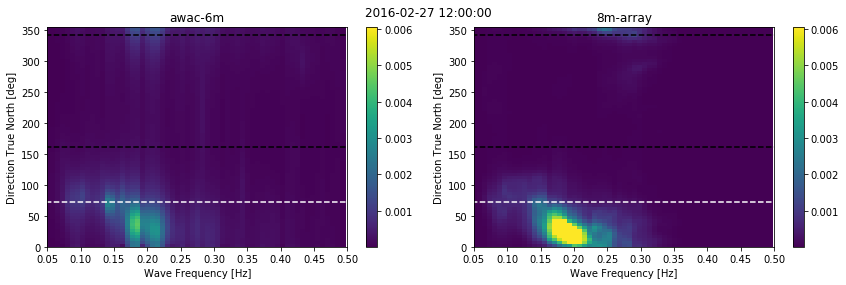

2016-03-03 07:00:00
awac-6m FP H_s: 1.21 [m] D_m 37.13 [deg] ........ 8m-array FP H_s: 1.21 [m] D_m: 34.53 [deg]
awac-6m HP H_s: 1.08 [m] D_m 47.36 [deg] ........ 8m-array HP H_s: 1.15 [m] D_m: 38.78 [deg]
HP diff     H_s: 0.14 [m] D_m -10.23 [deg] ........             H_s: 0.06 [m] D_m: -4.25 [deg]


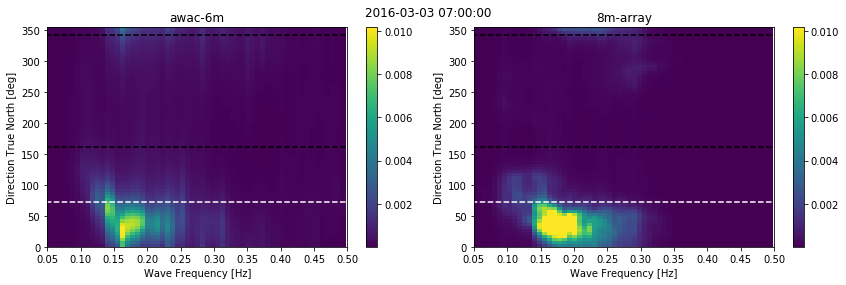

2016-03-25 12:00:00
awac-6m FP H_s: 0.88 [m] D_m 111.89 [deg] ........ 8m-array FP H_s: 0.88 [m] D_m: 108.37 [deg]
awac-6m HP H_s: 0.78 [m] D_m 100.90 [deg] ........ 8m-array HP H_s: 0.82 [m] D_m: 103.27 [deg]
HP diff     H_s: 0.10 [m] D_m 10.99 [deg] ........             H_s: 0.07 [m] D_m: 5.10 [deg]


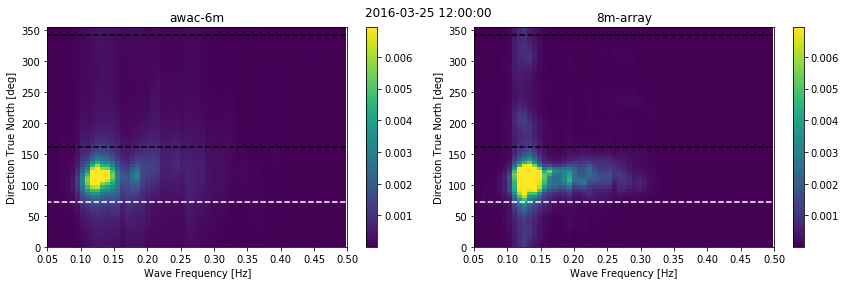

2016-03-25 22:00:00
awac-6m FP H_s: 0.84 [m] D_m 109.57 [deg] ........ 8m-array FP H_s: 0.82 [m] D_m: 106.41 [deg]
awac-6m HP H_s: 0.73 [m] D_m 97.95 [deg] ........ 8m-array HP H_s: 0.78 [m] D_m: 102.52 [deg]
HP diff     H_s: 0.11 [m] D_m 11.62 [deg] ........             H_s: 0.04 [m] D_m: 3.89 [deg]


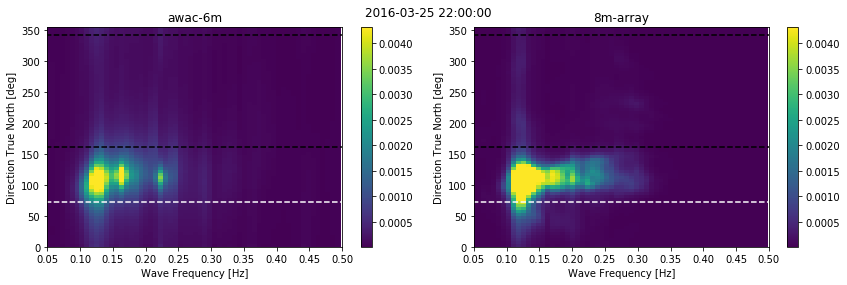

2016-03-26 00:00:00
awac-6m FP H_s: 0.83 [m] D_m 108.46 [deg] ........ 8m-array FP H_s: 0.78 [m] D_m: 105.35 [deg]
awac-6m HP H_s: 0.73 [m] D_m 98.02 [deg] ........ 8m-array HP H_s: 0.73 [m] D_m: 100.60 [deg]
HP diff     H_s: 0.10 [m] D_m 10.43 [deg] ........             H_s: 0.06 [m] D_m: 4.76 [deg]


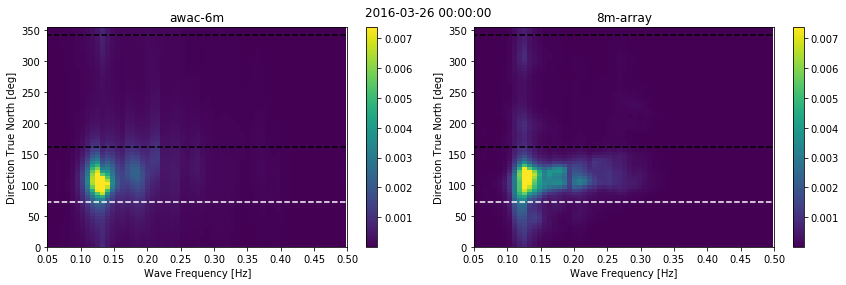

2016-03-31 19:00:00
awac-6m FP H_s: 0.88 [m] D_m 105.27 [deg] ........ 8m-array FP H_s: 0.83 [m] D_m: 106.50 [deg]
awac-6m HP H_s: 0.77 [m] D_m 92.92 [deg] ........ 8m-array HP H_s: 0.79 [m] D_m: 102.39 [deg]
HP diff     H_s: 0.11 [m] D_m 12.36 [deg] ........             H_s: 0.04 [m] D_m: 4.11 [deg]


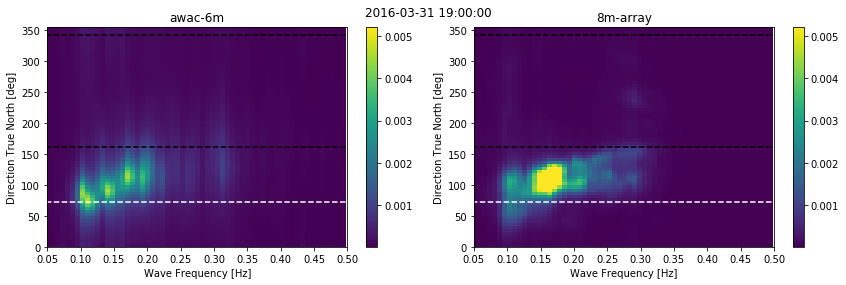

2016-03-31 20:00:00
awac-6m FP H_s: 0.81 [m] D_m 104.58 [deg] ........ 8m-array FP H_s: 0.82 [m] D_m: 105.05 [deg]
awac-6m HP H_s: 0.71 [m] D_m 92.48 [deg] ........ 8m-array HP H_s: 0.78 [m] D_m: 101.43 [deg]
HP diff     H_s: 0.11 [m] D_m 12.10 [deg] ........             H_s: 0.04 [m] D_m: 3.62 [deg]


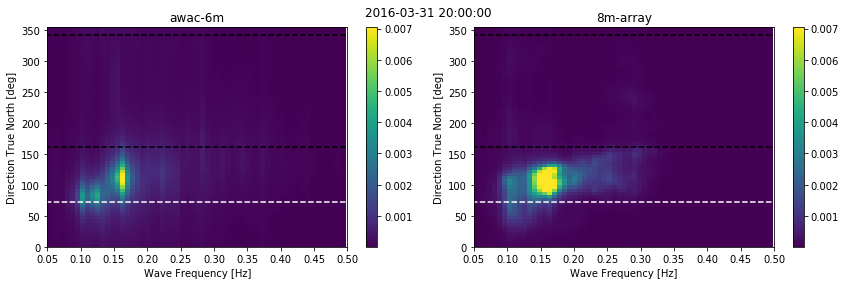

2016-04-03 09:00:00
awac-6m FP H_s: 0.78 [m] D_m 25.22 [deg] ........ 8m-array FP H_s: 0.81 [m] D_m: 5.54 [deg]
awac-6m HP H_s: 0.65 [m] D_m 47.09 [deg] ........ 8m-array HP H_s: 0.71 [m] D_m: 18.28 [deg]
HP diff     H_s: 0.13 [m] D_m -21.87 [deg] ........             H_s: 0.09 [m] D_m: -12.74 [deg]


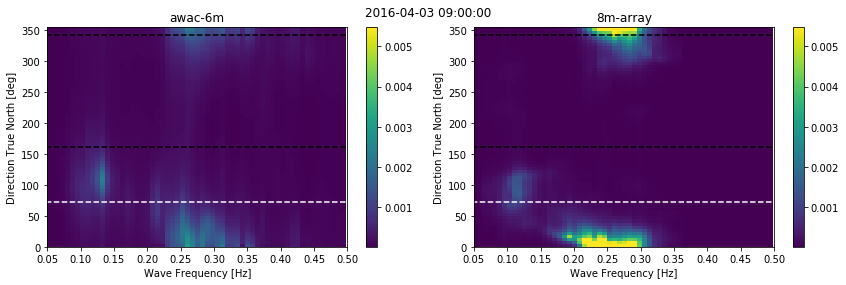

2016-04-03 11:00:00
awac-6m FP H_s: 0.96 [m] D_m 24.40 [deg] ........ 8m-array FP H_s: 0.94 [m] D_m: 15.66 [deg]
awac-6m HP H_s: 0.83 [m] D_m 39.48 [deg] ........ 8m-array HP H_s: 0.88 [m] D_m: 22.82 [deg]
HP diff     H_s: 0.13 [m] D_m -15.08 [deg] ........             H_s: 0.07 [m] D_m: -7.16 [deg]


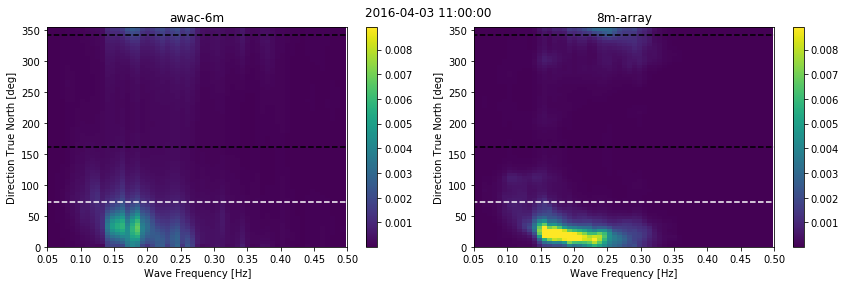

2016-04-03 12:00:00
awac-6m FP H_s: 0.87 [m] D_m 26.23 [deg] ........ 8m-array FP H_s: 0.91 [m] D_m: 16.53 [deg]
awac-6m HP H_s: 0.75 [m] D_m 40.96 [deg] ........ 8m-array HP H_s: 0.85 [m] D_m: 23.63 [deg]
HP diff     H_s: 0.12 [m] D_m -14.73 [deg] ........             H_s: 0.06 [m] D_m: -7.10 [deg]


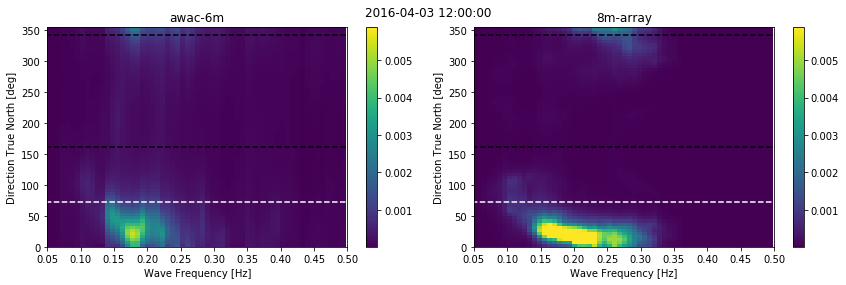

2016-04-03 13:00:00
awac-6m FP H_s: 0.98 [m] D_m 24.82 [deg] ........ 8m-array FP H_s: 0.93 [m] D_m: 16.05 [deg]
awac-6m HP H_s: 0.84 [m] D_m 40.50 [deg] ........ 8m-array HP H_s: 0.86 [m] D_m: 24.25 [deg]
HP diff     H_s: 0.14 [m] D_m -15.68 [deg] ........             H_s: 0.07 [m] D_m: -8.20 [deg]


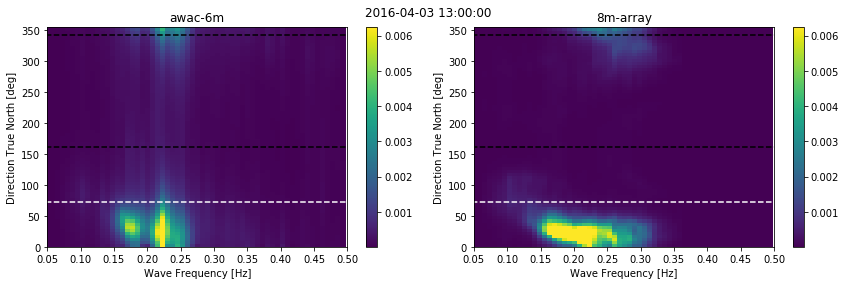

2016-04-03 18:00:00
awac-6m FP H_s: 0.85 [m] D_m 41.53 [deg] ........ 8m-array FP H_s: 0.88 [m] D_m: 36.94 [deg]
awac-6m HP H_s: 0.74 [m] D_m 52.78 [deg] ........ 8m-array HP H_s: 0.85 [m] D_m: 40.05 [deg]
HP diff     H_s: 0.11 [m] D_m -11.25 [deg] ........             H_s: 0.04 [m] D_m: -3.11 [deg]


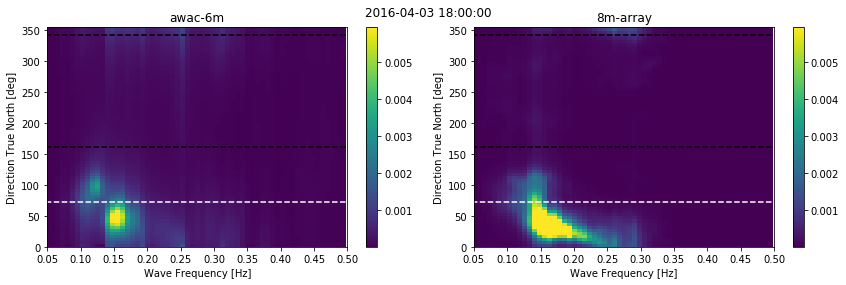

2016-04-24 09:00:00
awac-6m FP H_s: 0.90 [m] D_m 37.69 [deg] ........ 8m-array FP H_s: 0.85 [m] D_m: 50.54 [deg]
awac-6m HP H_s: 0.78 [m] D_m 49.07 [deg] ........ 8m-array HP H_s: 0.74 [m] D_m: 47.42 [deg]
HP diff     H_s: 0.12 [m] D_m -11.38 [deg] ........             H_s: 0.11 [m] D_m: 3.12 [deg]


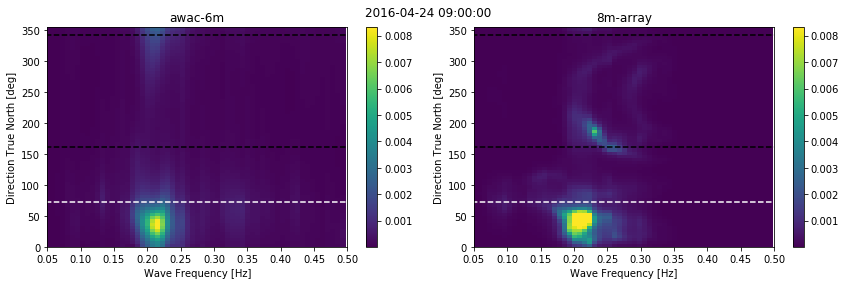

2016-04-24 11:00:00
awac-6m FP H_s: 0.96 [m] D_m 38.26 [deg] ........ 8m-array FP H_s: 1.00 [m] D_m: 51.37 [deg]
awac-6m HP H_s: 0.84 [m] D_m 48.66 [deg] ........ 8m-array HP H_s: 0.88 [m] D_m: 49.37 [deg]
HP diff     H_s: 0.12 [m] D_m -10.40 [deg] ........             H_s: 0.12 [m] D_m: 2.01 [deg]


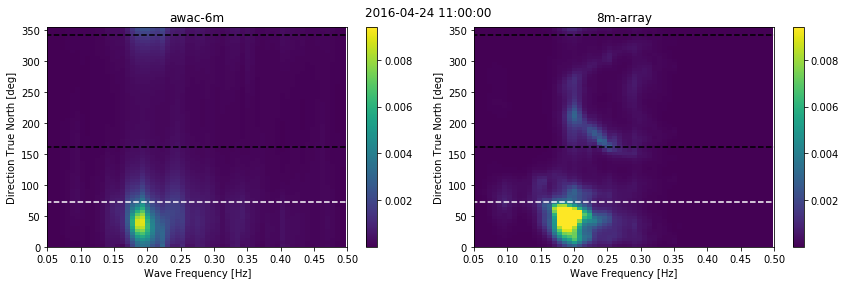

2016-08-22 11:00:00
awac-6m FP H_s: 0.78 [m] D_m 45.96 [deg] ........ 8m-array FP H_s: 0.74 [m] D_m: 25.88 [deg]
awac-6m HP H_s: 0.66 [m] D_m 56.68 [deg] ........ 8m-array HP H_s: 0.69 [m] D_m: 33.10 [deg]
HP diff     H_s: 0.11 [m] D_m -10.72 [deg] ........             H_s: 0.05 [m] D_m: -7.22 [deg]


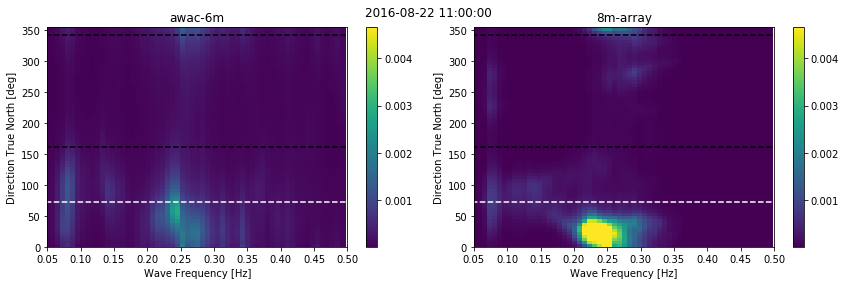

2016-08-22 12:00:00
awac-6m FP H_s: 0.79 [m] D_m 46.90 [deg] ........ 8m-array FP H_s: 0.79 [m] D_m: 28.65 [deg]
awac-6m HP H_s: 0.67 [m] D_m 57.06 [deg] ........ 8m-array HP H_s: 0.73 [m] D_m: 36.11 [deg]
HP diff     H_s: 0.12 [m] D_m -10.16 [deg] ........             H_s: 0.06 [m] D_m: -7.45 [deg]


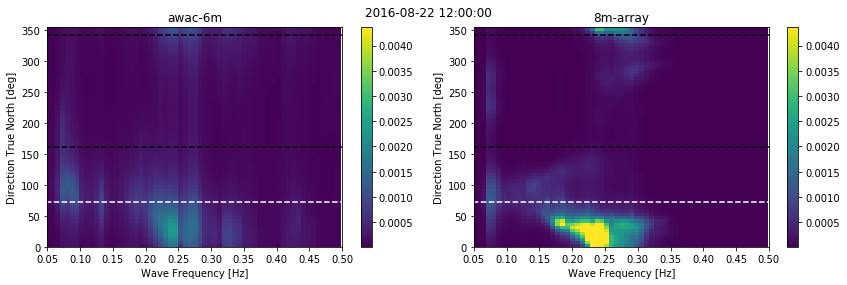

2016-08-22 13:00:00
awac-6m FP H_s: 0.93 [m] D_m 42.75 [deg] ........ 8m-array FP H_s: 0.90 [m] D_m: 35.17 [deg]
awac-6m HP H_s: 0.81 [m] D_m 53.09 [deg] ........ 8m-array HP H_s: 0.84 [m] D_m: 40.83 [deg]
HP diff     H_s: 0.12 [m] D_m -10.35 [deg] ........             H_s: 0.06 [m] D_m: -5.66 [deg]


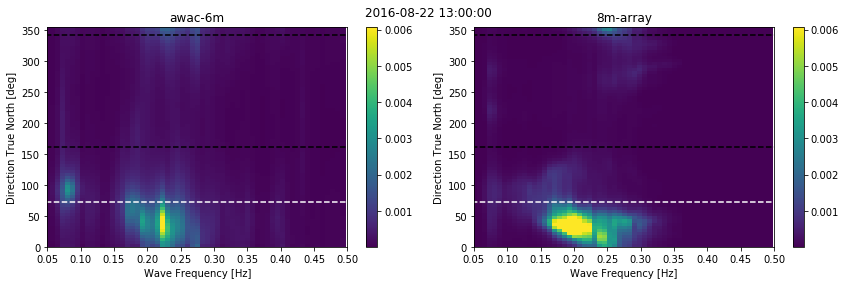

2016-09-19 20:00:00
awac-6m FP H_s: 0.76 [m] D_m 99.65 [deg] ........ 8m-array FP H_s: 0.73 [m] D_m: 95.64 [deg]
awac-6m HP H_s: 0.66 [m] D_m 88.35 [deg] ........ 8m-array HP H_s: 0.68 [m] D_m: 92.42 [deg]
HP diff     H_s: 0.10 [m] D_m 11.30 [deg] ........             H_s: 0.04 [m] D_m: 3.22 [deg]


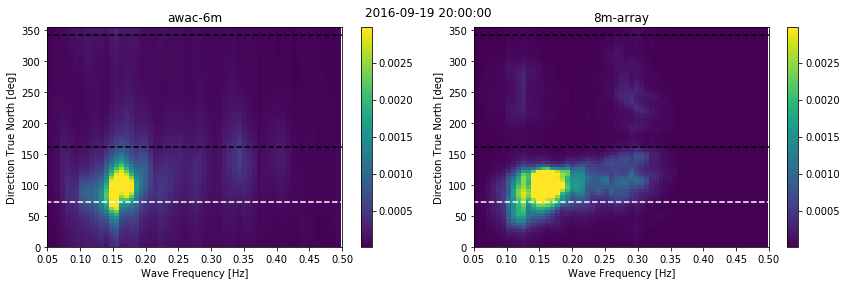

2016-09-28 11:00:00
awac-6m FP H_s: 0.90 [m] D_m 106.06 [deg] ........ 8m-array FP H_s: 0.92 [m] D_m: 96.87 [deg]
awac-6m HP H_s: 0.80 [m] D_m 95.77 [deg] ........ 8m-array HP H_s: 0.84 [m] D_m: 91.07 [deg]
HP diff     H_s: 0.10 [m] D_m 10.28 [deg] ........             H_s: 0.08 [m] D_m: 5.80 [deg]


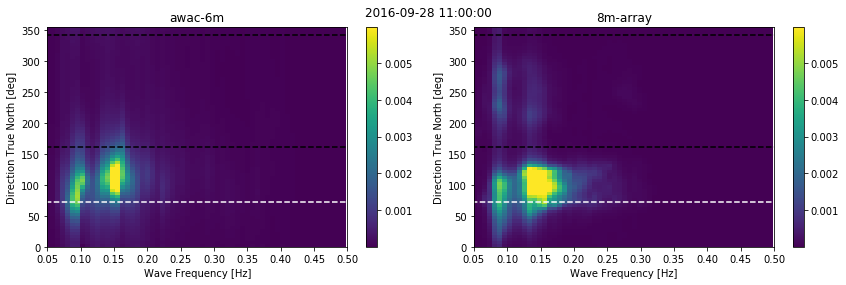

In [242]:
for idxOfInterest in idxHighResidual:
    if np.abs(obs_bulkStat_FP['Hm0'][idxOfInterest] - mod_bulkStat_FP['Hm0'][idxOfInterest]) > 0.05:
        continue
    
    vmin = 0.00001#min(obs_matched['dWED'][idxOfInterest].min(), mod_matched['dWED'][idxOfInterest].min())
    vmax = max(obs_matched['dWED'][idxOfInterest].max(), mod_matched['dWED'][idxOfInterest].max()) * 0.5
    plt.figure(figsize=(12, 4))
    plt.suptitle(obs_matched['time'][idxOfInterest])
    plt.subplot(121)
    plt.pcolormesh(obs_matched['wavefreqbin'], obs_matched['wavedirbin'], obs_matched['dWED'][idxOfInterest].T, vmin=vmin, vmax=vmax)
    plt.title(obslabel)
    plt.plot([0, 0.5], [72, 72], 'w--')
    plt.plot([0, 0.5], [72+90, 72+90], 'k--')
    plt.plot([0, 0.5], [342, 342], 'k--')
    plt.xlim([0.05, 0.5])
    plt.colorbar()
    plt.ylabel('Direction True North [deg]')
    plt.xlabel('Wave Frequency [Hz]')
    plt.subplot(122)
    plt.title(modlabel)
    plt.pcolormesh(mod_matched['wavefreqbin'], mod_matched['wavedirbin'], mod_matched['dWED'][idxOfInterest].T, vmin=vmin, vmax=vmax)
    plt.plot([0, 0.5], [72, 72], 'w--')
    plt.plot([0, 0.5], [72+90, 72+90], 'k--')
    plt.plot([0, 0.5], [342, 342], 'k--')
    plt.xlim([0.05, 0.5])
    plt.colorbar()
    plt.ylabel('Direction True North [deg]')
    plt.xlabel('Wave Frequency [Hz]')
    plt.tight_layout()
    print(obs_matched['time'][idxOfInterest])
    print('{} FP H_s: {:.2f} [m] D_m {:.2f} [deg] ........ {} FP H_s: {:.2f} [m] D_m: {:.2f} [deg]'.format(obslabel, obs_bulkStat_FP['Hm0'][idxOfInterest], obs_bulkStat_FP['Dm'][idxOfInterest], modlabel, mod_bulkStat_FP['Hm0'][idxOfInterest], mod_bulkStat_FP['Dm'][idxOfInterest]))
    print('{} HP H_s: {:.2f} [m] D_m {:.2f} [deg] ........ {} HP H_s: {:.2f} [m] D_m: {:.2f} [deg]'.format(obslabel, obs_bulkStat_HP['Hm0'][idxOfInterest], obs_bulkStat_HP['Dm'][idxOfInterest], modlabel, mod_bulkStat_HP['Hm0'][idxOfInterest], mod_bulkStat_HP['Dm'][idxOfInterest]))
    print('HP diff     H_s: {:.2f} [m] D_m {:.2f} [deg] ........             H_s: {:.2f} [m] D_m: {:.2f} [deg]'.format((obs_bulkStat_FP['Hm0'][idxOfInterest] - obs_bulkStat_HP['Hm0'][idxOfInterest]), (obs_bulkStat_FP['Dm'][idxOfInterest] - obs_bulkStat_HP['Dm'][idxOfInterest]), (mod_bulkStat_FP['Hm0'][idxOfInterest] - mod_bulkStat_HP['Hm0'][idxOfInterest]), (mod_bulkStat_FP['Dm'][idxOfInterest] - mod_bulkStat_HP['Dm'][idxOfInterest])  ))

    plt.show()
